<a href="https://colab.research.google.com/github/naveedAnjumMian/Time-Series-Anomaly-Detection/blob/main/survey_experimentalWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

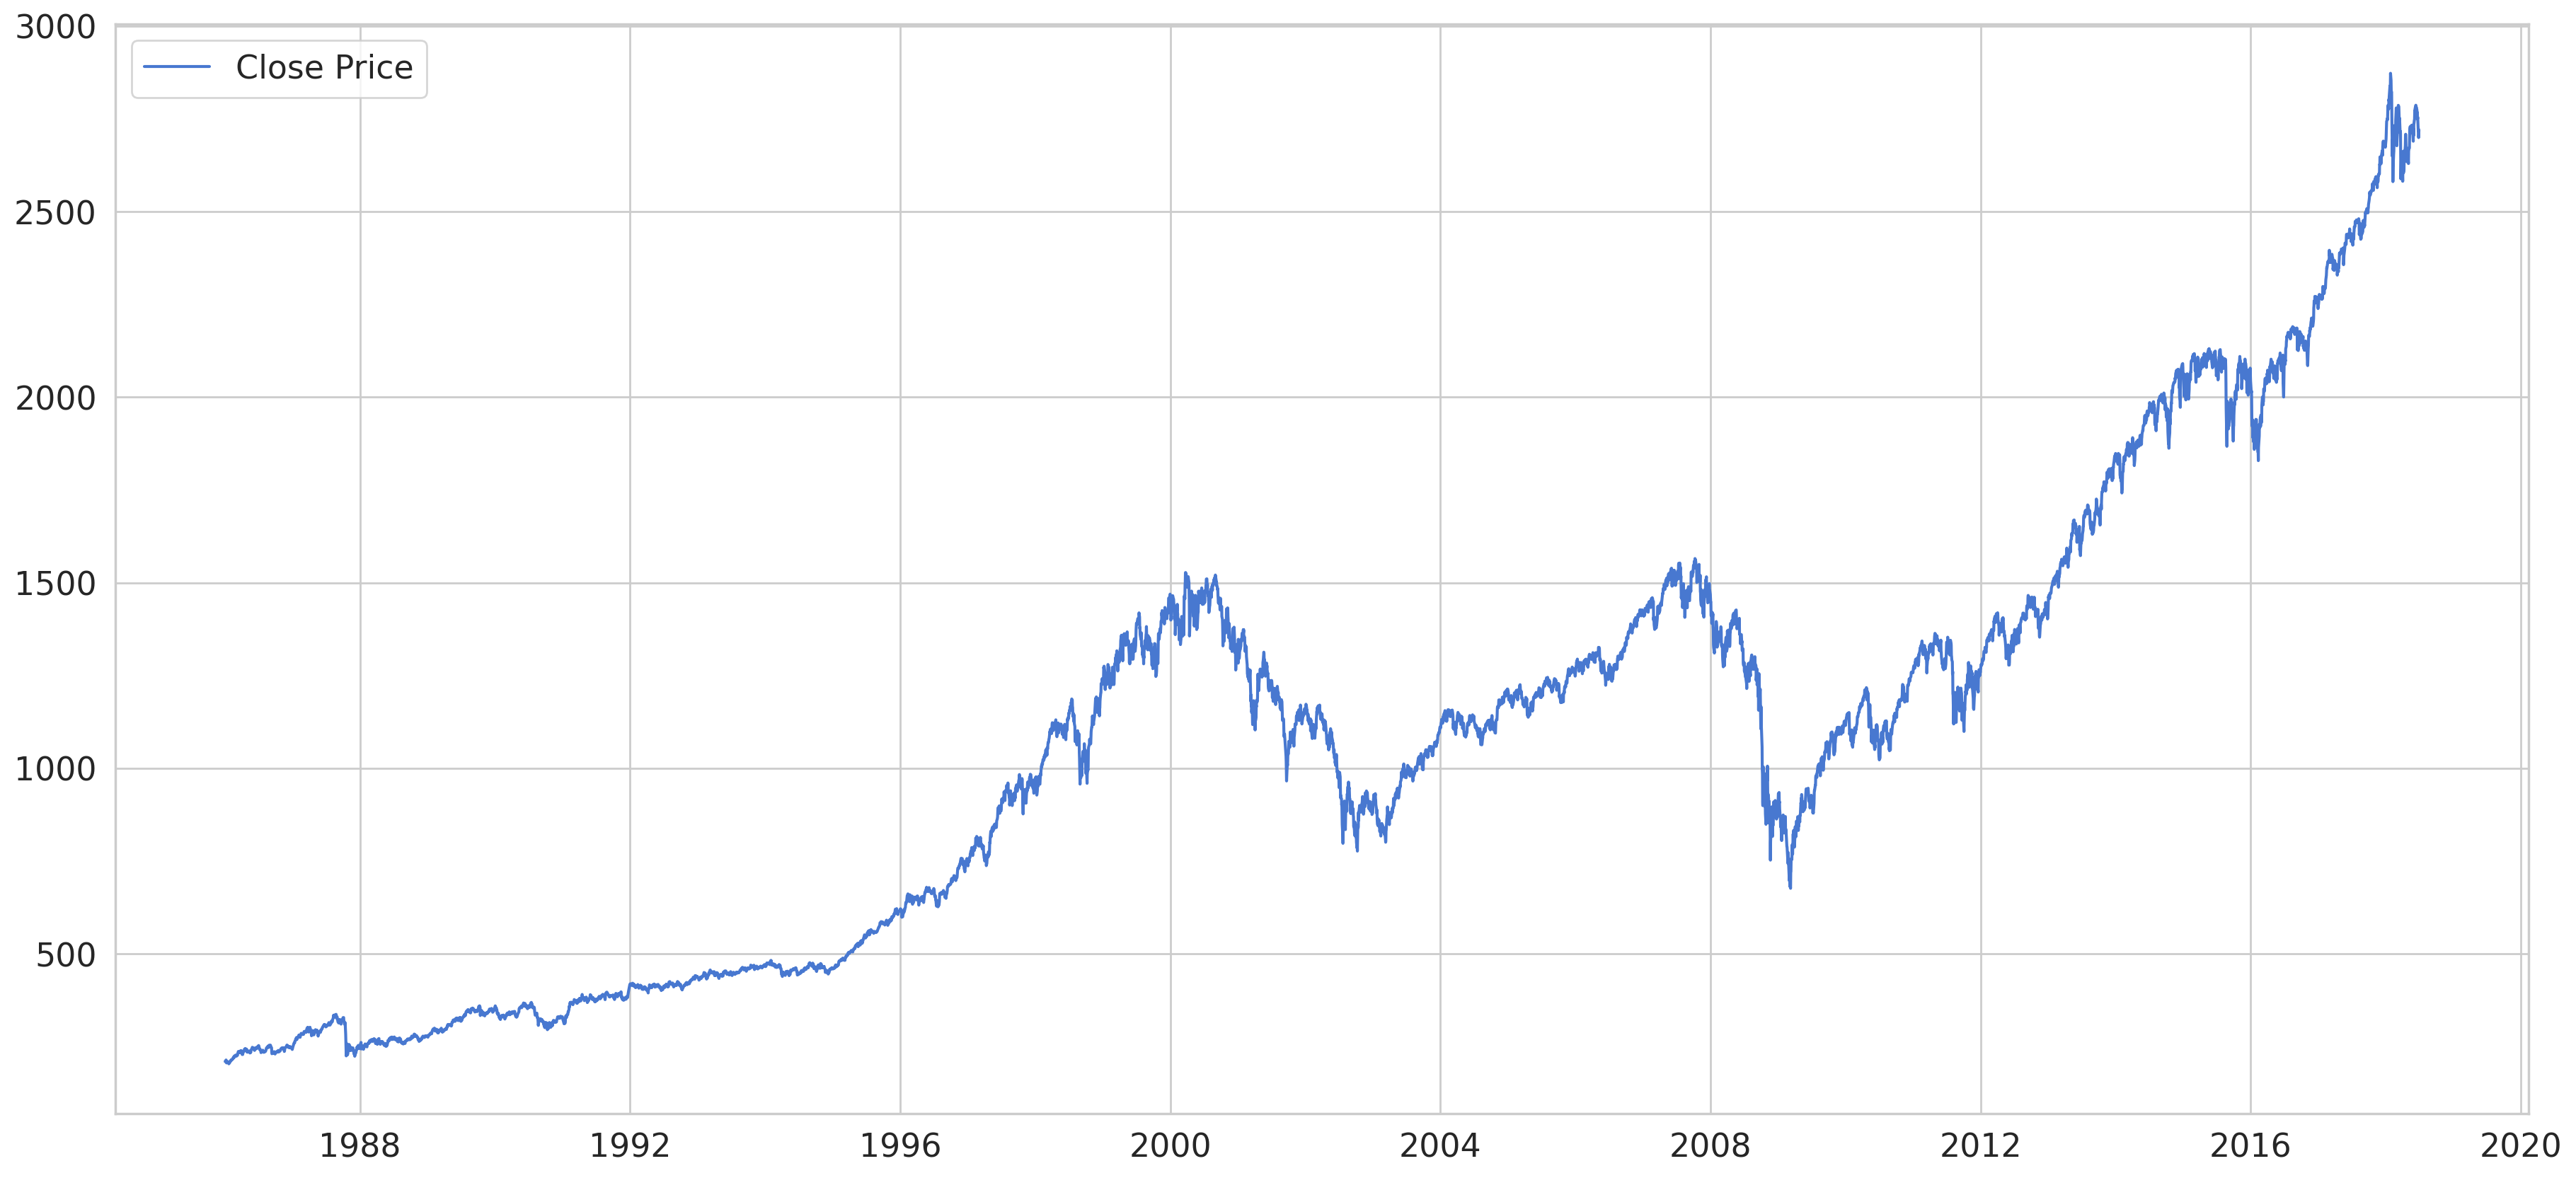

In [ ]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')
plt.plot(df, label='Close Price')
plt.legend()

In [ ]:

train_size = int(len(df) * 0.93)
test_size = int(len(df)) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[['close']])
train['close'] = scaler.transform(train[['close']])
test['close']  = scaler.transform(test[['close']])
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS  = 30

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], train.close, TIME_STEPS)
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64,
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)


<ipython-input-3-dd3d8ff53279>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['close'] = scaler.transform(train[['close']])
<ipython-input-3-dd3d8ff53279>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['close']  = scaler.transform(test[['close']])


Epoch 1/10
214/214 [==============================] - 22s 26ms/step - loss: 0.1760 - val_loss: 0.4866
Epoch 2/10
214/214 [==============================] - 3s 14ms/step - loss: 0.1110 - val_loss: 0.3186
Epoch 3/10
214/214 [==============================] - 2s 9ms/step - loss: 0.0867 - val_loss: 0.2954
Epoch 4/10
214/214 [==============================] - 2s 9ms/step - loss: 0.1014 - val_loss: 0.2706
Epoch 5/10
214/214 [==============================] - 1s 7ms/step - loss: 0.1034 - val_loss: 0.2914
Epoch 6/10
214/214 [==============================] - 2s 7ms/step - loss: 0.1208 - val_loss: 0.2577
Epoch 7/10
214/214 [==============================] - 2s 7ms/step - loss: 0.1229 - val_loss: 0.2638
Epoch 8/10
214/214 [==============================] - 2s 10ms/step - loss: 0.1248 - val_loss: 0.2093
Epoch 9/10
214/214 [==============================] - 1s 7ms/step - loss: 0.1289 - val_loss: 0.2094
Epoch 10/10
214/214 [==============================] - 1s 7ms/step - loss: 0.1297 - val_loss: 0.

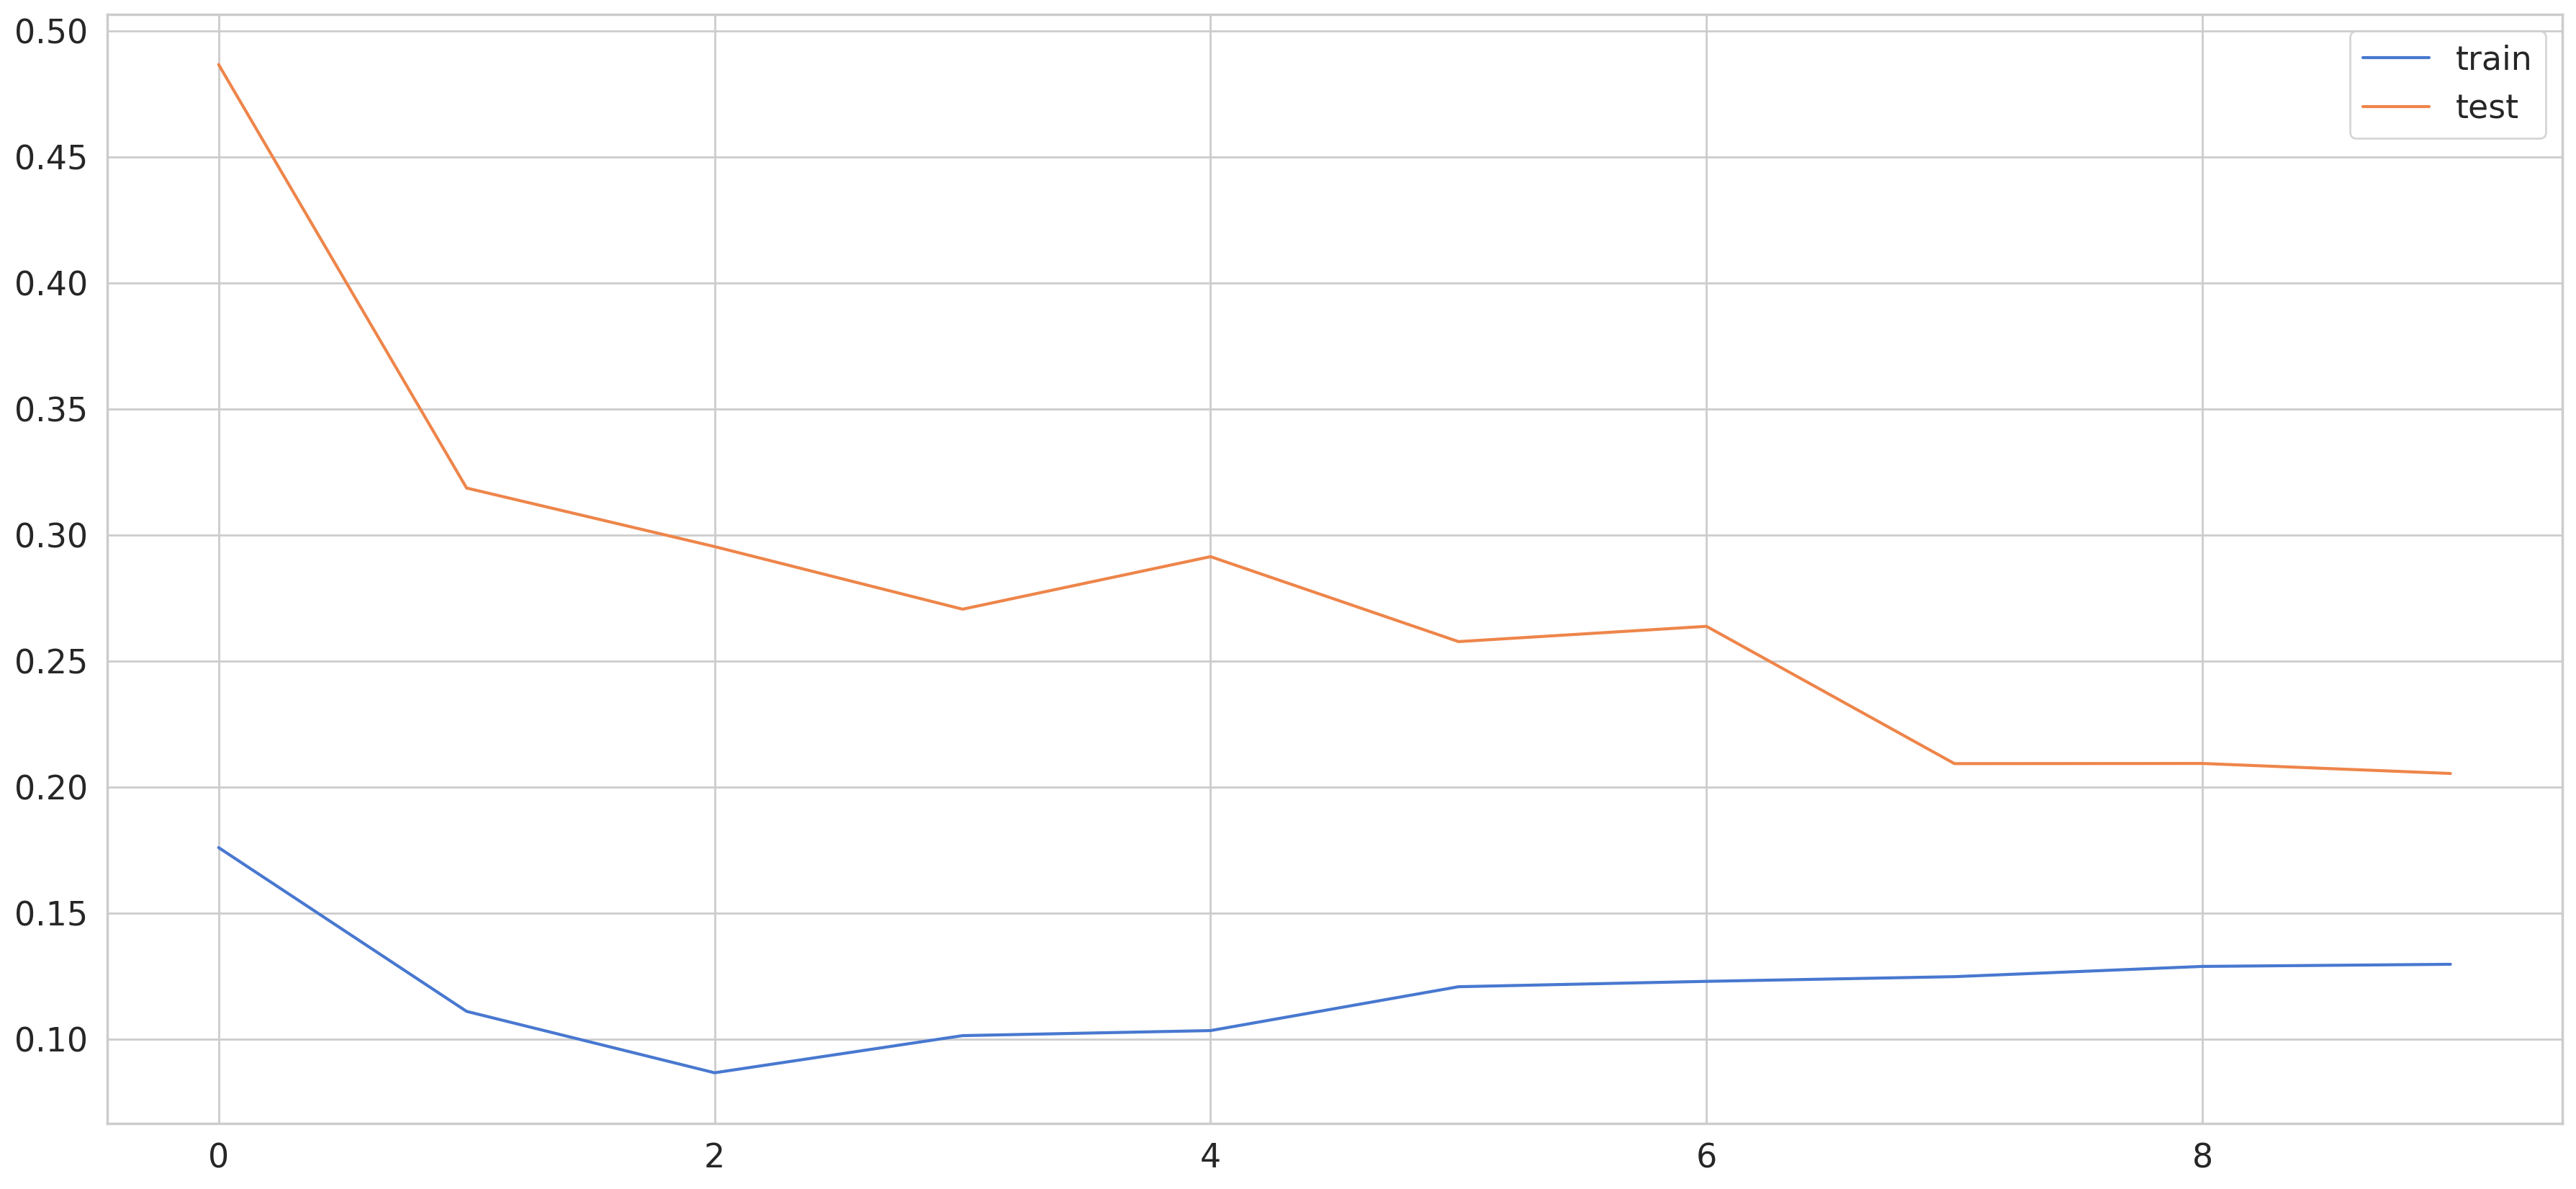

In [ ]:
history.history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [ ]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

238/238 [==============================] - 1s 3ms/step


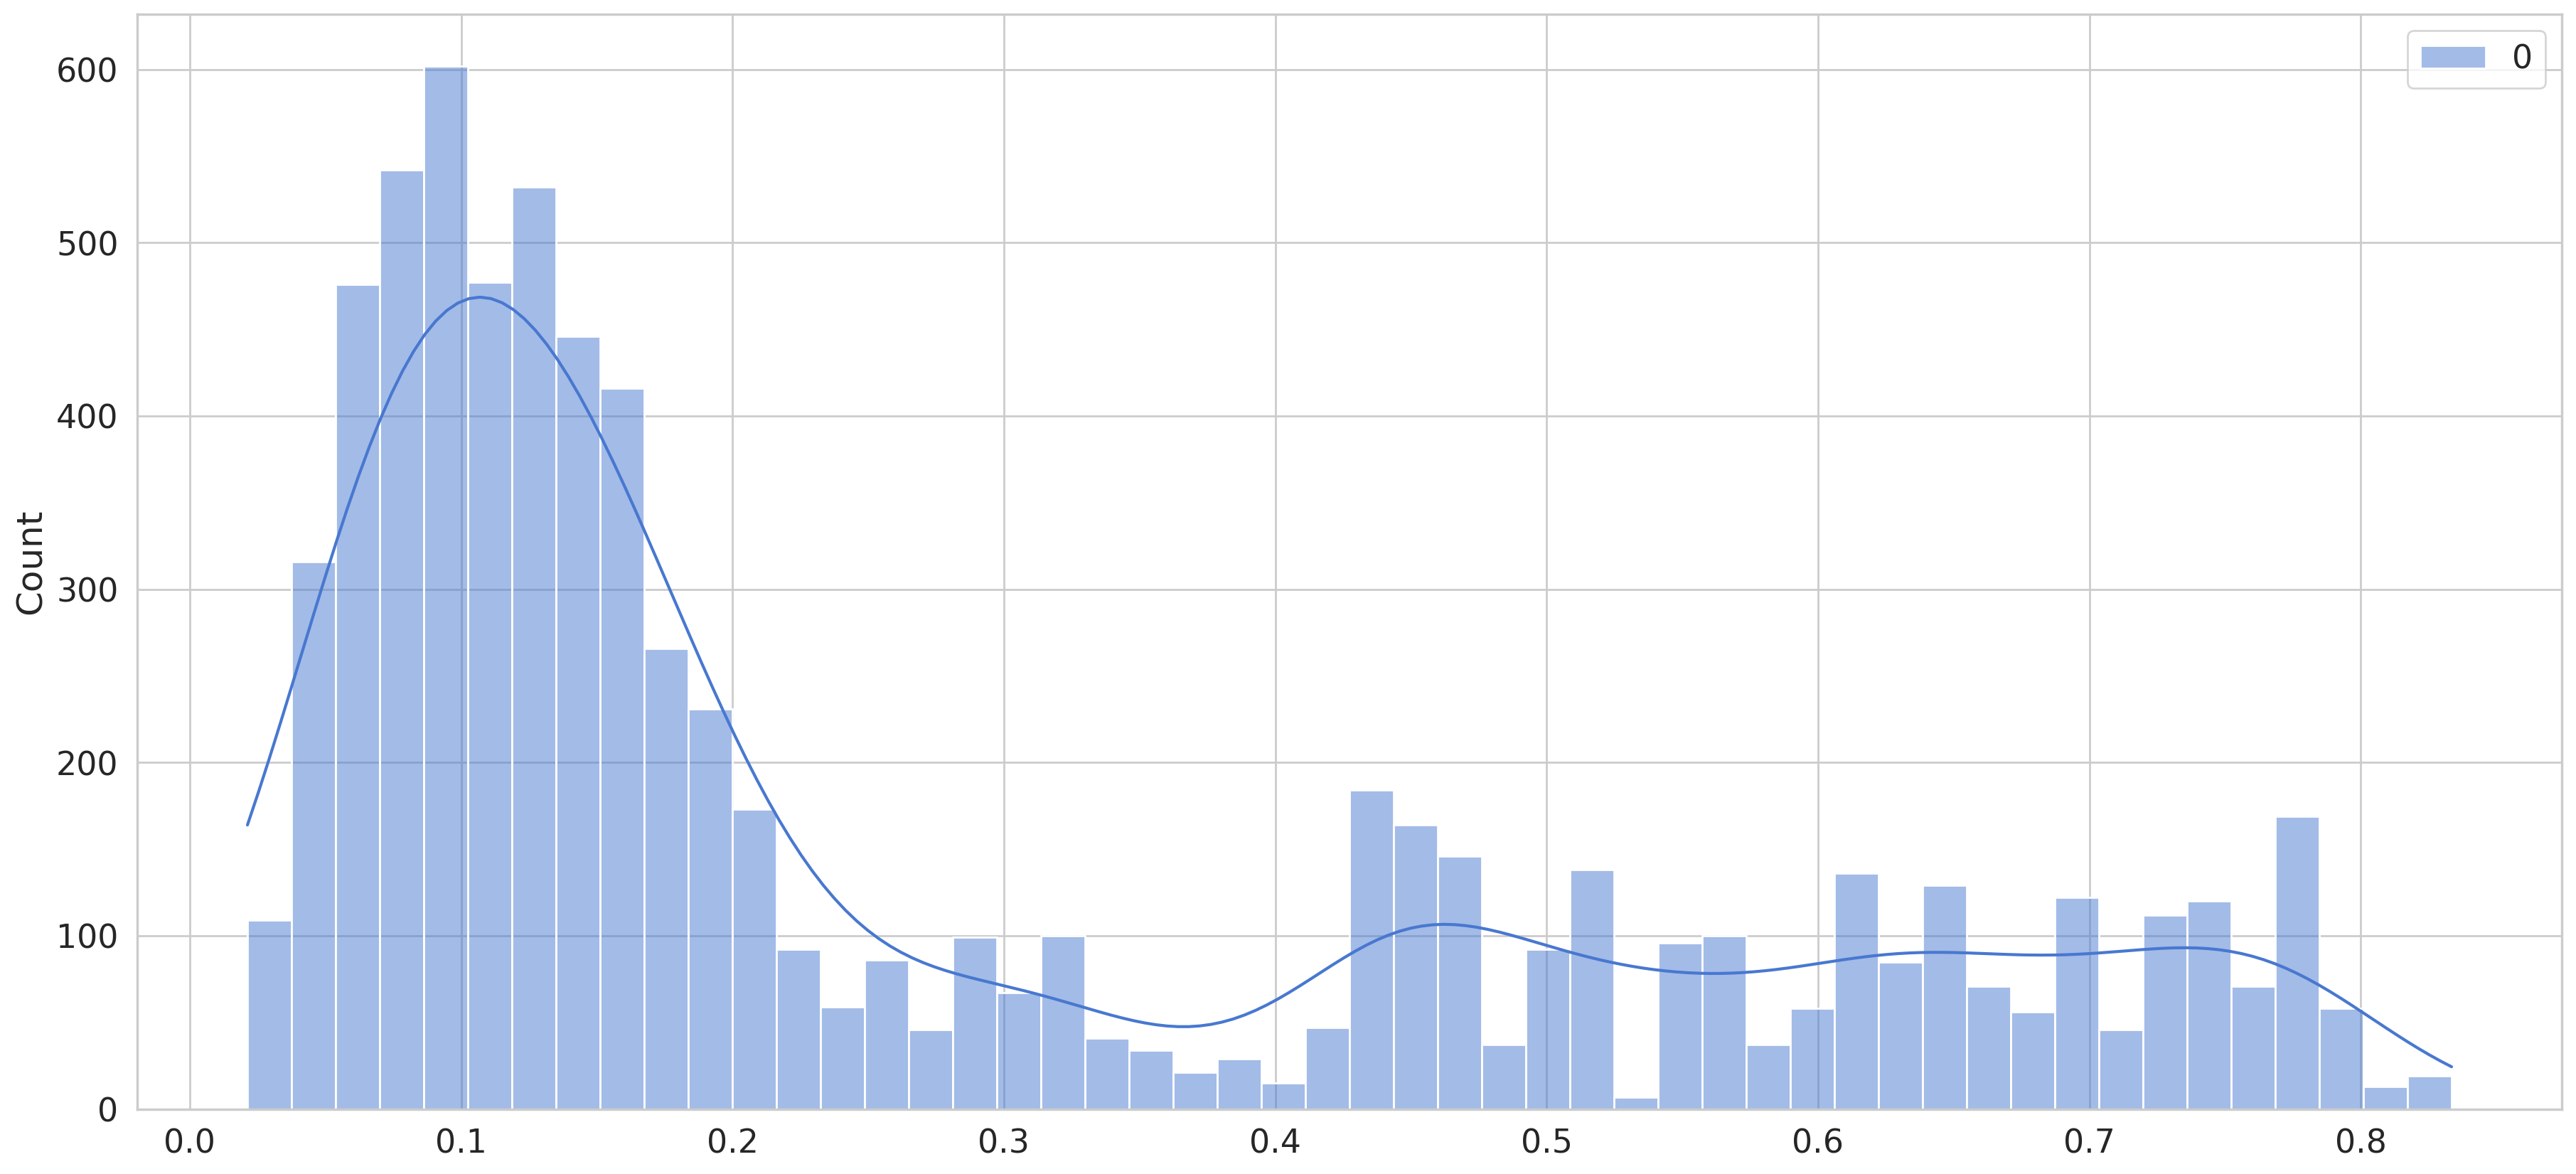

In [ ]:
sns.histplot(train_mae_loss, bins=50, kde=True);

17/17 [==============================] - 0s 3ms/step


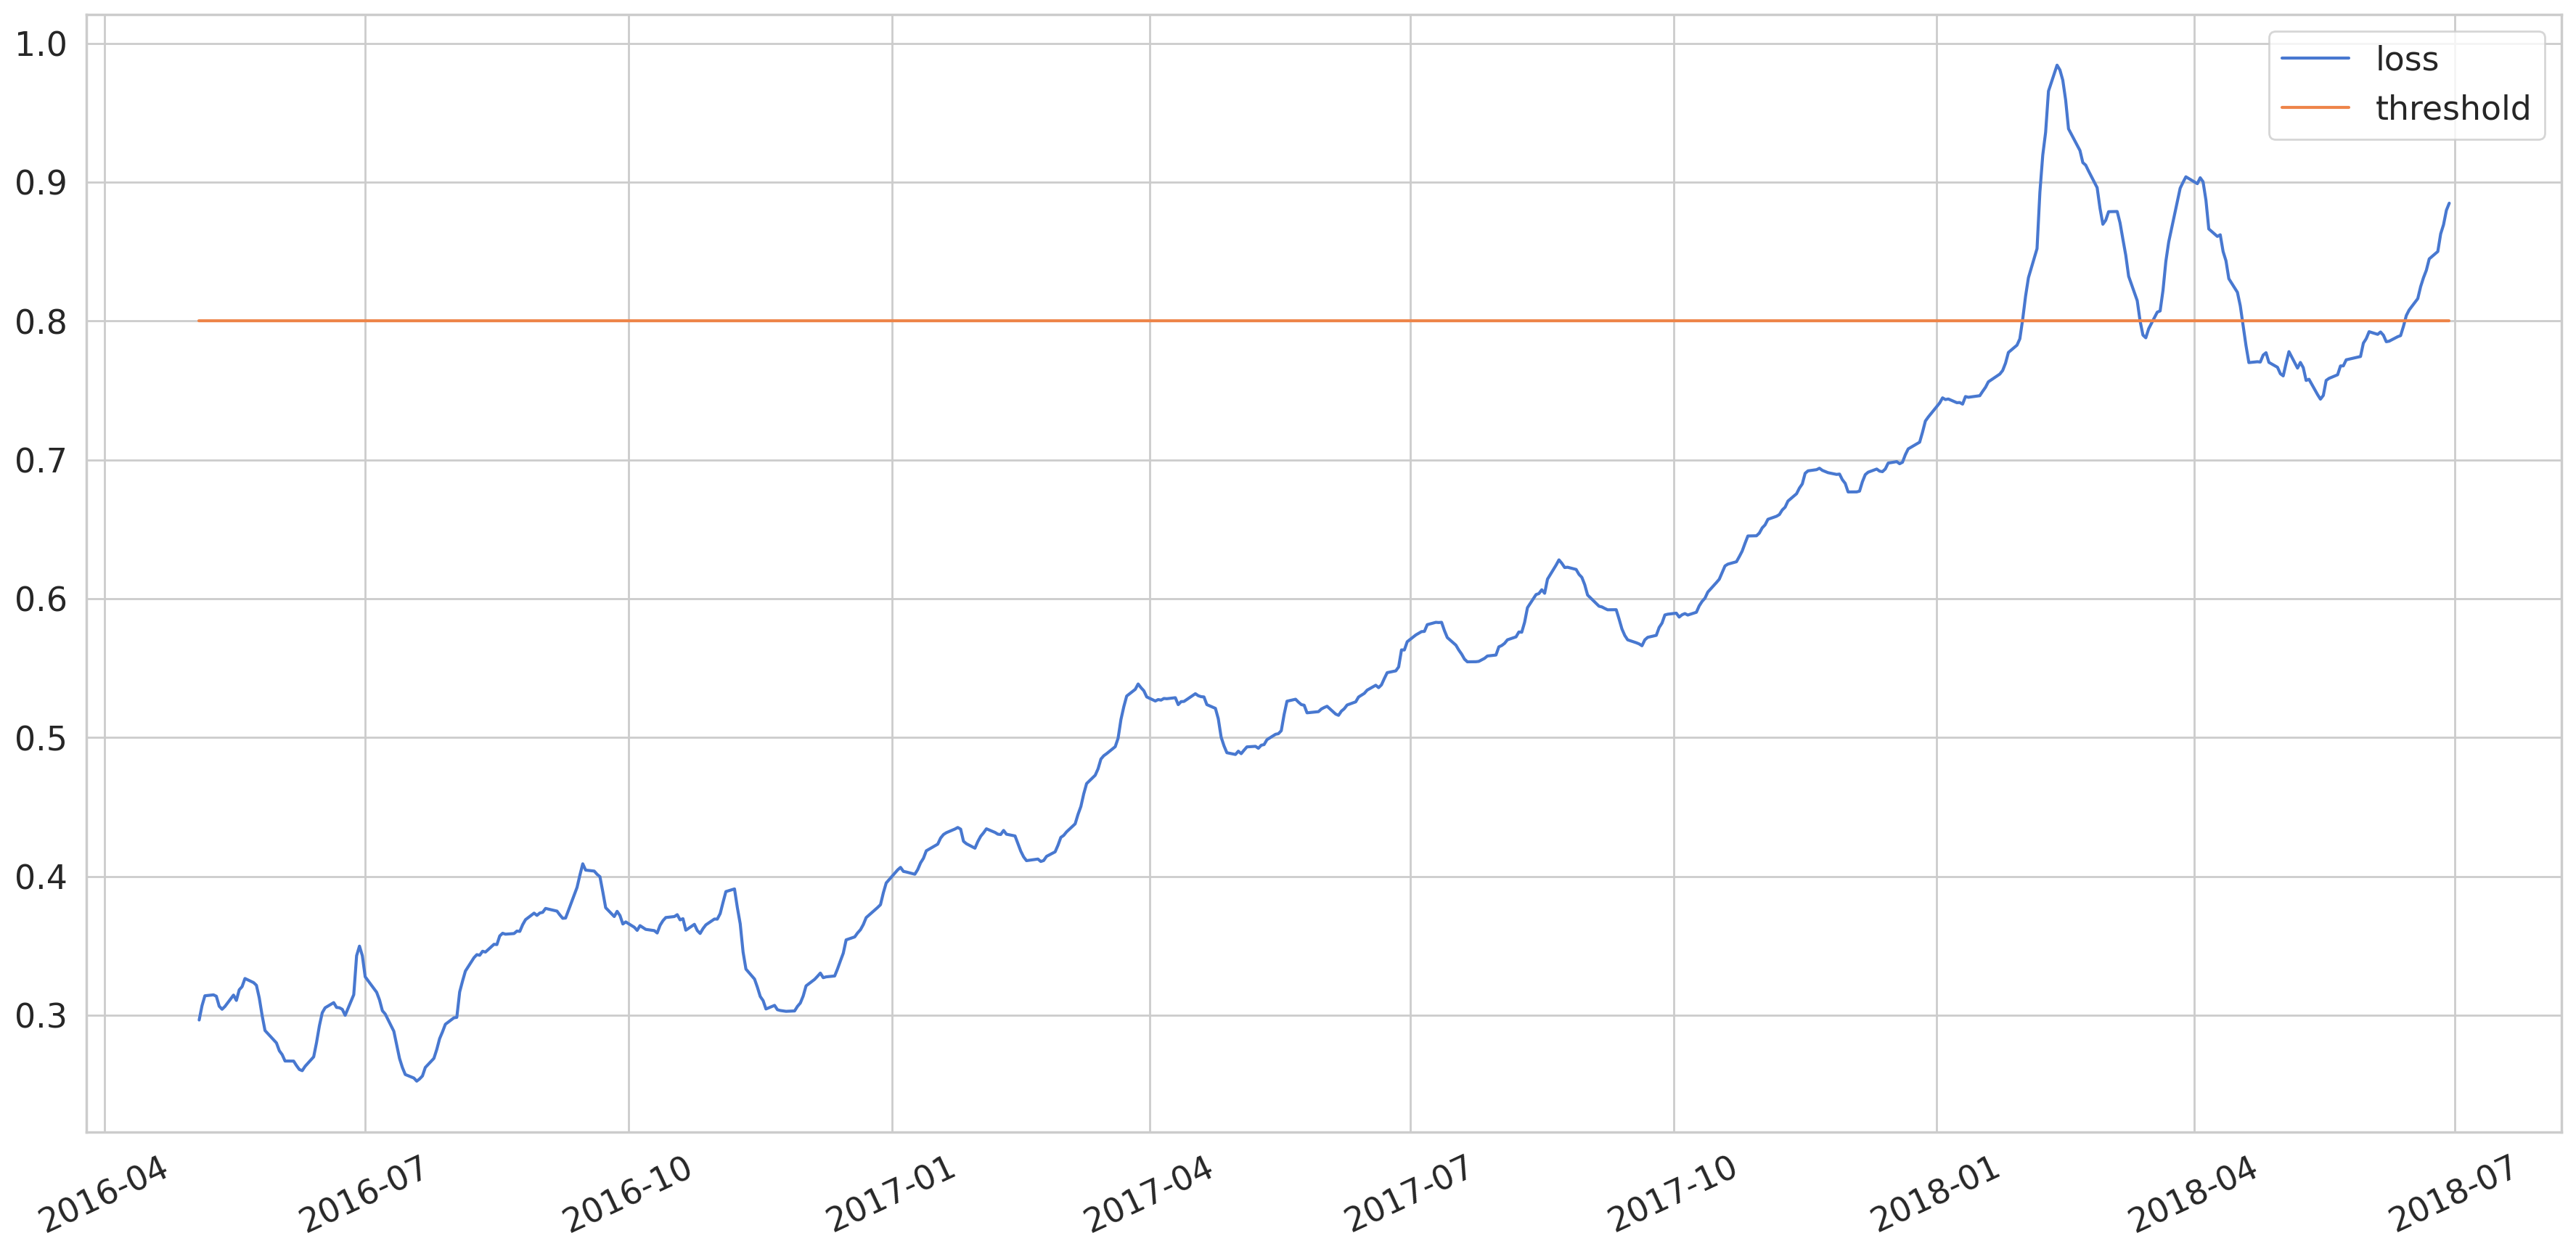

In [ ]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
THRESHOLD = 0.80
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close
test_score_df['Date'] = test_score_df.index
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

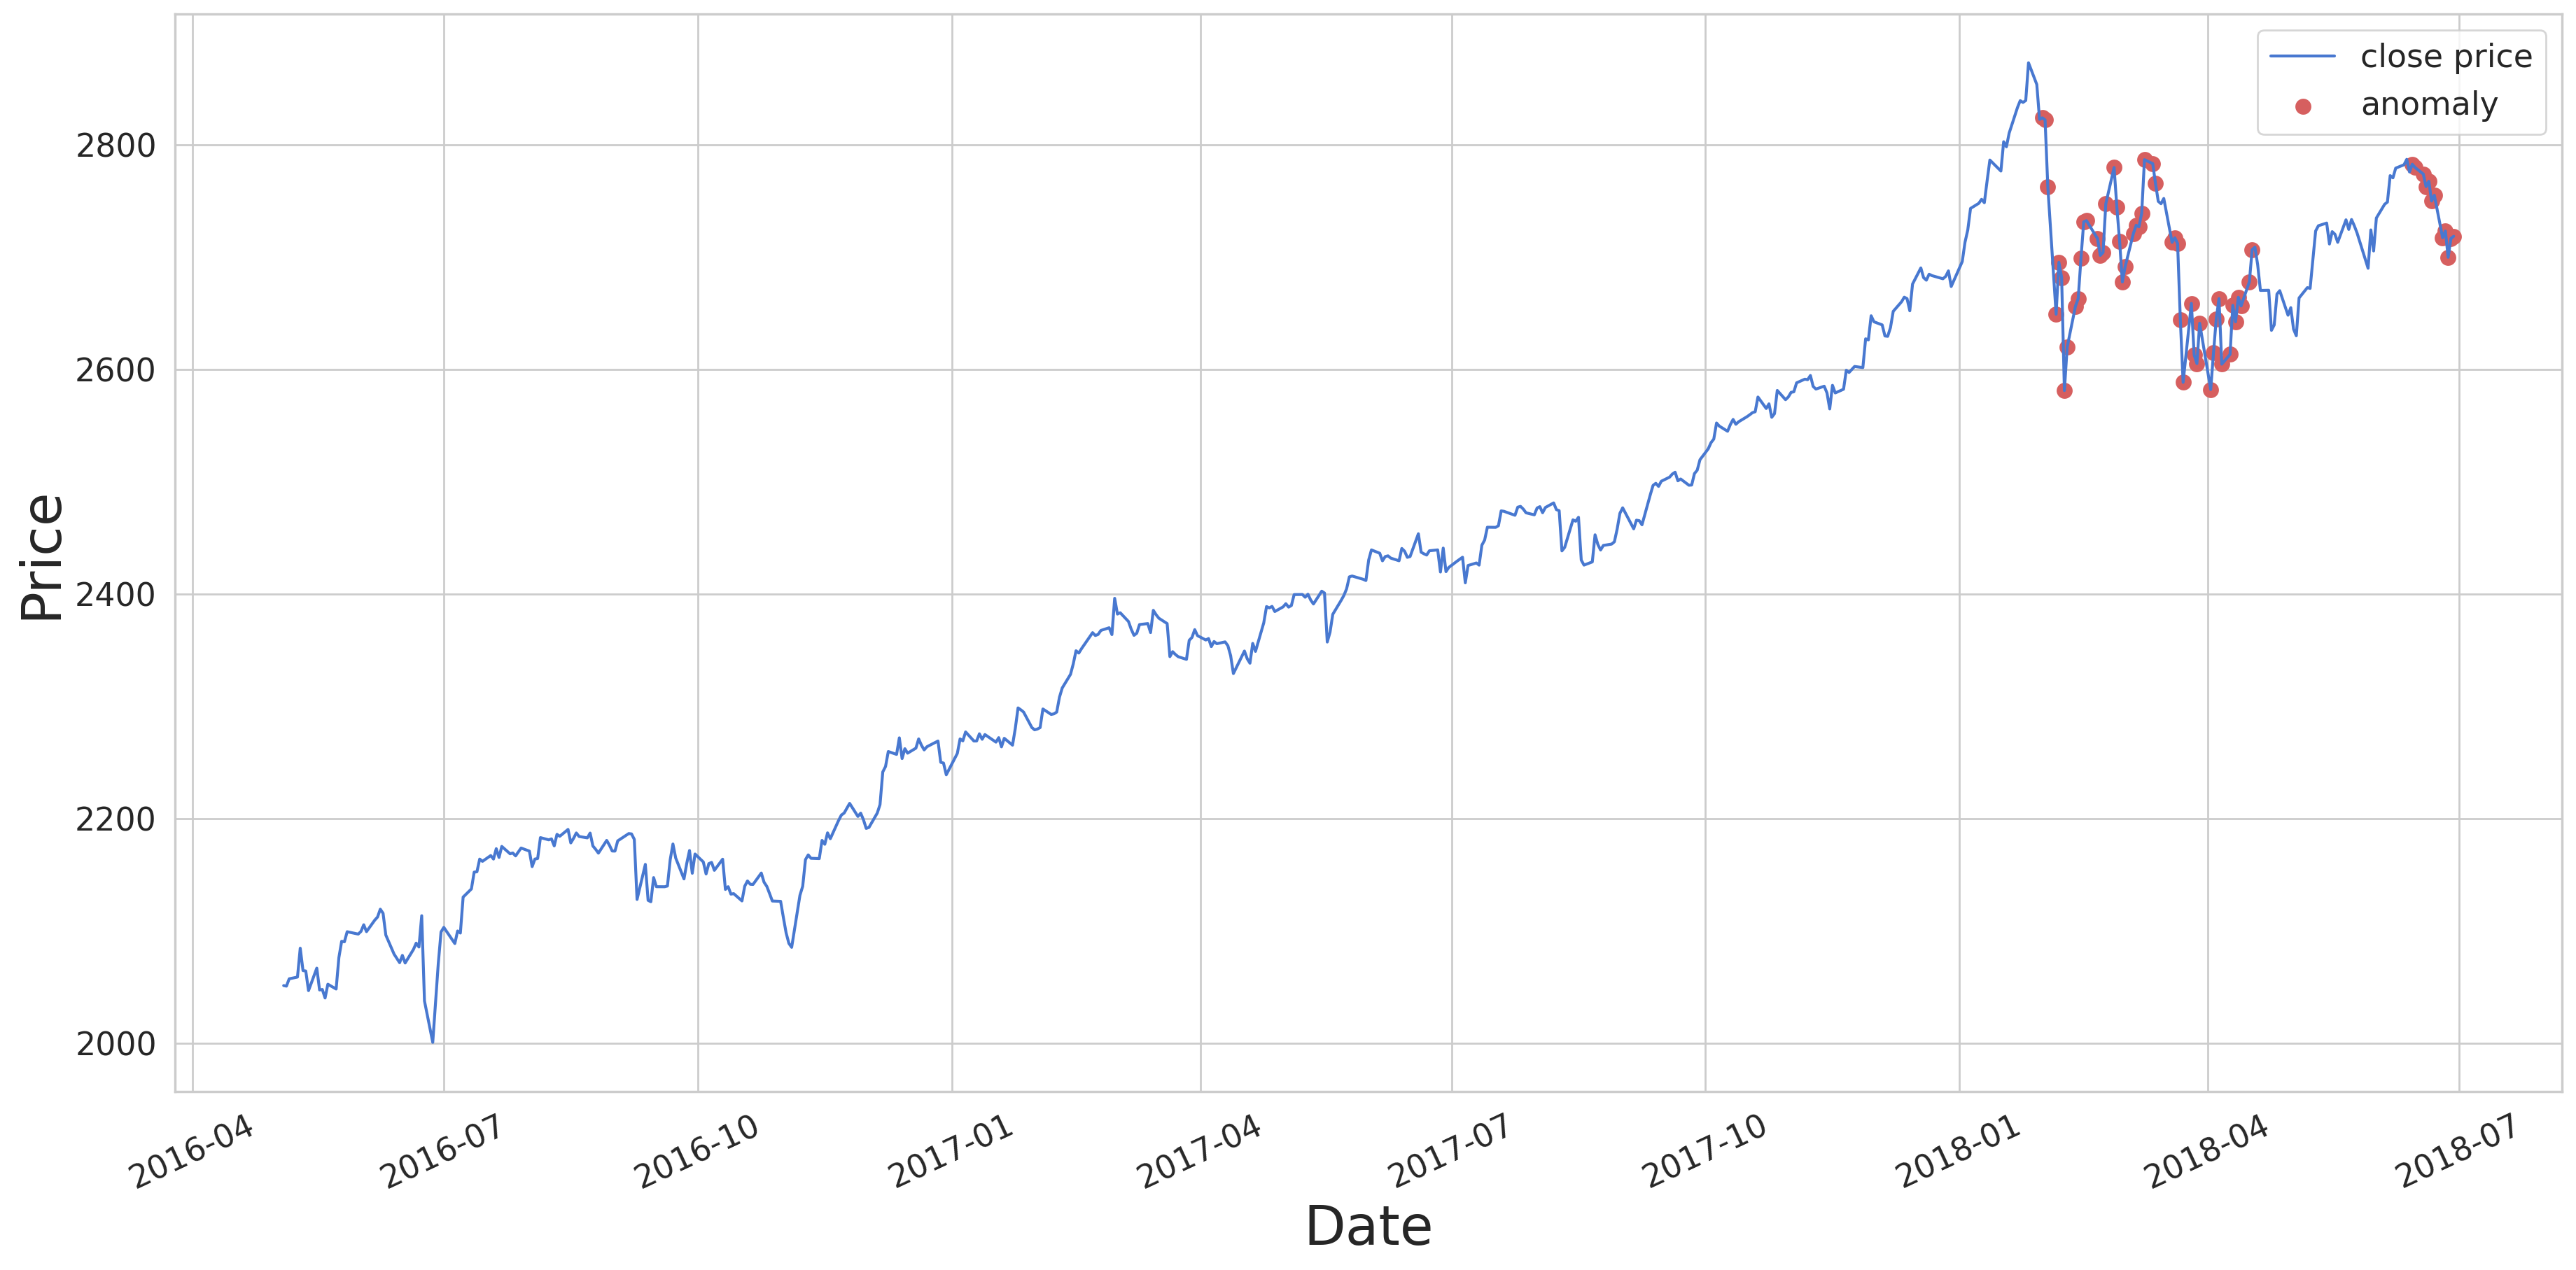

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
check = test[TIME_STEPS:].close
A_convert = check.to_numpy()
F_convert = A_convert.reshape(-1,1)

an_check = anomalies.close
AF_convert = an_check.to_numpy()
Fin_convert = AF_convert.reshape(-1,1)

indexck = anomalies.index
ind= indexck.to_numpy()
Find = ind.reshape(-1,1)
anomalies.index
plt.plot(
  test[TIME_STEPS:].index,
  scaler.inverse_transform(F_convert),
  label='close price'
);

plt.scatter(
    anomalies.index,
    scaler.inverse_transform(Fin_convert),
    color='r',
    s=52,
    label='anomaly'
   )
plt.xlabel("Date",fontsize=28)
plt.ylabel("Price", fontsize=28)
plt.xticks(rotation=25)
plt.legend();